In [1]:
import numpy as np
from matplotlib import pyplot as plt

import random

import torch
from torch.nn import functional as F

from model import NGram

## Load Data


In [2]:
words = open("../../data/names.txt", "r").read().splitlines()

chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

block_size = 3
X, Y = [], []


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [3]:
def cross_entropy(logits, Y):
    logits = (
        logits - logits.max(1, keepdim=True).values
    )  # so exp doesn't overflow 2 inf
    counts = logits.exp()
    prob = counts / counts.sum(1, keepdim=True)
    loss = -prob[torch.arange(len(logits)), Y].log().mean()
    return loss

## Train


In [4]:
batch_size = 32
n_iters = 100_000
lr = 0.1

m = NGram()
losses = []


def train(m, X, Y, n_iters, batch_size):
    losses = []
    for i in range(n_iters):
        # mini-batch
        ix = torch.randint(0, len(X), (batch_size,))
        logits = m.forward(X[ix])

        loss = cross_entropy(logits, Ytr[ix])
        losses.append(loss.item())  # mini-batch loss

        if i % 20_000 == 0:
            print(loss.item())

        for p in m.parameters:
            p.grad = None

        loss.backward()

        for p in m.parameters:
            p.data += -lr * p.grad
    return losses

no.of paramters: 3581


In [5]:
losses += train(m, Xtr, Ytr, 1, batch_size)
losses

3.3176753520965576


[3.3176753520965576]

3.289440631866455
1.8901108503341675
2.3435301780700684
2.665682077407837
2.204488515853882


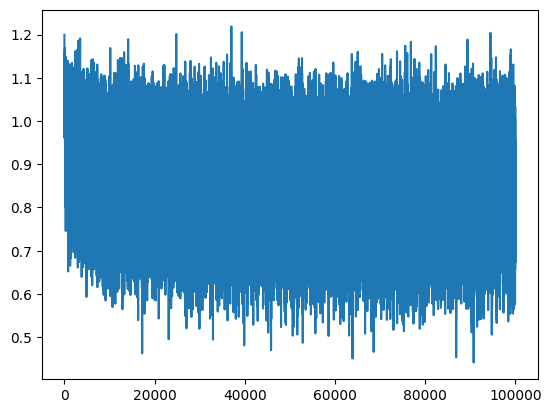

In [6]:
losses += train(m, Xtr, Ytr, n_iters, batch_size)
plt.plot(range(len(losses)), np.log(losses))

### Total loss


In [7]:
logits = m.predict(Xtr)
loss = cross_entropy(logits, Ytr)
loss

tensor(2.2861, grad_fn=<NegBackward0>)

In [8]:
logits = m.predict(Xdev)
loss = cross_entropy(logits, Ydev)
loss

tensor(2.2916, grad_fn=<NegBackward0>)

In [10]:
def predict(n=10):
    for i in range(n):
        out = []
        context = [0] * 3
        while True:
            logits = m.predict(context)
            probs = F.softmax(logits, 1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(itos[ix])
            if ix == 0:
                break
        print("".join(out))


predict()

mach.
darvidionishia.
alyso.
jayiar.
matsrestyn.
sifitli.
anosymanni.
barya.
dam.
mas.
